In [1]:
import os
import pathlib
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_label_dir(df):
    class_names = np.sort(df['label'].unique())
    number_of_classes = len(class_names)

    if not os.path.exists('../gdsc-ai-challenge/train'):
        return class_names, number_of_classes

    for class_name in class_names:
        dir = pathlib.Path('../gdsc-ai-challenge/train/' + class_name)
        if dir.exists():
            continue
        else:
            dir.mkdir()
    
    return class_names, number_of_classes

def sort_data(df):
    if not os.path.exists('../gdsc-ai-challenge/train'):
        return
        
    for image_dir in [str(img) for img in list(pathlib.Path('../gdsc-ai-challenge/train/train').glob('*.png'))]:
        id = int(image_dir.removeprefix('../gdsc-ai-challenge/train/train/').removesuffix('.png'))
        label = df['label'][id - 1]
        dest_path = os.path.join('../gdsc-ai-challenge/train', label, str(id) + '.png')
        shutil.move(image_dir, dest_path)

In [3]:
label_df = pd.read_csv('../gdsc-ai-challenge/trainLabels.csv')

class_names, number_of_classes = create_label_dir(label_df)
sort_data(label_df)

In [4]:
builder = tf.keras.utils.image_dataset_from_directory(
    '../gdsc-ai-challenge/train',
    color_mode='grayscale',
    batch_size=None,
    image_size=(32,32),
    seed=42
)

Found 50000 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-14 10:41:07.995619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 10:41:07.995796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

def configure_for_performance(ds, batch_size=32):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(builder, 50000, train_split=0.7, val_split=0.2, test_split=0.1)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [7]:
model = keras.models.Sequential([
    keras.layers.Input((32,32,1)),
    keras.layers.Conv2D(32, (5,5), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (5,5), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-3)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-3)),
    keras.layers.Dense(number_of_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                                              loss='sparse_categorical_crossentropy',
                                              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [9]:
class stopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('accuracy') >= 0.999 and 
            logs.get('val_accuracy') >= 0.999) :
            print('\nReached 99.9% accuracy so stopping training')
            self.model.stop_training = True

In [10]:
callback = stopCallback()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='../Model/aiseries/version1.hdf5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

history = model.fit(train_ds, 
                    epochs=20, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=val_ds)

Epoch 1/20


2022-03-14 10:41:09.104712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 10:41:09.104853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - ETA: 0s - loss: 27.0970 - accuracy: 0.2264

2022-03-14 10:42:25.578587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - 89s 80ms/step - loss: 27.0970 - accuracy: 0.2264 - val_loss: 11.0926 - val_accuracy: 0.2250
Epoch 2/20
1094/1094 [==============================] - 85s 78ms/step - loss: 9.2912 - accuracy: 0.3251 - val_loss: 7.1166 - val_accuracy: 0.3379
Epoch 3/20
1094/1094 [==============================] - 88s 80ms/step - loss: 6.2172 - accuracy: 0.4027 - val_loss: 5.5311 - val_accuracy: 0.3567
Epoch 4/20
1094/1094 [==============================] - 87s 79ms/step - loss: 4.7063 - accuracy: 0.4530 - val_loss: 4.3107 - val_accuracy: 0.4058
Epoch 5/20
1094/1094 [==============================] - 87s 80ms/step - loss: 3.7686 - accuracy: 0.4901 - val_loss: 3.4330 - val_accuracy: 0.4899
Epoch 6/20
1094/1094 [==============================] - 85s 78ms/step - loss: 3.1563 - accuracy: 0.5179 - val_loss: 3.1239 - val_accuracy: 0.4610
Epoch 7/20
1094/1094 [==============================] - 87s 79ms/step - loss: 2.6848 - accuracy: 0.5447 - val_loss: 2.5803 - val_accu

In [11]:
model.evaluate(test_ds)

157/157 [==============================] - 7s 29ms/step - loss: 1.5683 - accuracy: 0.6228


[1.5682982206344604, 0.6228000521659851]

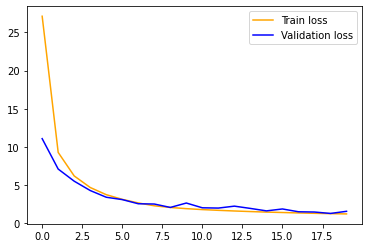

In [12]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.legend()
plt.show()